In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
# !pip install tqdm
from tqdm import tqdm
# !pip install Pillow==4.1.1

In [ ]:
import torchvision.datasets as dset

In [ ]:
import torch.nn as nn
#import torchvision.datasets as dset
from torch .autograd import Variable
import  torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image
import torchvision.utils as vutils
from IPython.display import clear_output
import datetime
from tqdm import tqdm

In [ ]:
from  torch.utils.data  import Dataset , DataLoader

In [ ]:
torch.__version__

'1.6.0+cu101'

In [ ]:
training_dir = "/content/drive/My Drive/face_rotate/dataset/train"
test_dir = "/content/drive/My Drive/face_rotate/dataset/test"

In [ ]:
folder_dataset = dset.ImageFolder(root=training_dir)

In [ ]:
scale = 255
class get_Dataset(Dataset):
    def __init__(self, imageFolderDataset):
        self.imageFolderDataset = imageFolderDataset 
        self.len = int(len(self.imageFolderDataset.imgs)/2)
        self.object = np.ones((self.len, 1, 128, 128))
        self.target = np.ones((self.len, 1, 128, 128))
        l = 0  
        k = 0
        for i in range(0, 1552, 1):
            if(l < 4):
                self.object[k][0] = cv2.resize(cv2.imread(self.imageFolderDataset.imgs[i][0], 0),  (128,128))
                self.target[k][0] = cv2.resize(cv2.imread(self.imageFolderDataset.imgs[i+1][0], 0),  (128,128))
                l = l + 1
                k = k + 1
            elif(l == 7):
                l = 0
            else:
                l = l + 1
            print(i)
        self.object = torch.from_numpy(((self.object/(scale / 2)) -1 )).double()
        self.target = torch.from_numpy(((self.target/(scale / 2)) -1 )).double()

    def __getitem__(self,index):
        return self.object[index] ,  self.target[index]        
        
    def __len__(self):
        return self.len   


In [ ]:
train_dataset = get_Dataset(imageFolderDataset = folder_dataset)    

In [ ]:
train_loader = DataLoader(train_dataset , batch_size = 20 , shuffle = True )

In [ ]:
class G(nn.Module):

    def __init__(self):
        super(G, self).__init__()
        
        self.conv1 =    nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.relu1 =     nn.LeakyReLU(0.2)#128 * 64* 64
    
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.relu2 =     nn.LeakyReLU(0.2)#256* 32*32
            
        self.conv3 =     nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.relu3 =    nn.LeakyReLU(0.2)#512*16*16
            
        self.conv4 =    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.relu4 =    nn.LeakyReLU(0.2)#512*8*8
        
        self.batchnorm1 = nn.BatchNorm2d(512)
            
        self.conv5 =     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.relu5 =   nn.LeakyReLU(0.2)#512*4*4
        self.conv6 =  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.relu6 =     nn.LeakyReLU(0.2)#512*2*2
            #decoder
        self.deconv1 =   nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1)#4
        self.relu8 =    nn.LeakyReLU(0.2)#512*4*4
            
        self.deconv2 =     nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1)#8
        self.relu9 =    nn.LeakyReLU(0.2)#512*8*8
            
        self.deconv3 =   nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1)#16
        self.relu10 =    nn.LeakyReLU(0.2)#512*16*16
        
        self.batchnorm2 = nn.BatchNorm2d(512)
        
        self.deconv4 =    nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=4, stride=2, padding=1)#32
        self.relu11 =    nn.LeakyReLU(0.2)#256*32*32
            
        self.deconv5 =    nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=4, stride=2, padding=1)#64
        self.relu12 =    nn.LeakyReLU(0.2)#128*64*64
            
        self.deconv6 =   nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)#128
        self.relu13 =    nn.LeakyReLU(0.2)#128*128*128
            
        self.deconv7 =    nn.ConvTranspose2d(in_channels=128, out_channels=1 ,  kernel_size=1, stride  = 1, padding=0)#1*128*128
        self.relu14 =    nn.LeakyReLU(0.2)
        self.tanh =   nn.Tanh()

    def forward(self, input):
        out1 = self.conv1(input)
        out2= self.relu1(out1)#64
        out3 = self.conv2(out2)
        out4 = self.relu2(out3)#32
        out5 = self.conv3(out4)
        out6 = self.relu3(out5)#16
        out7 = self.conv4(out6)
        out8 = self.relu4(out7)#8
        out_batchnorm1 = self.batchnorm1(out8)
        out9 = self.conv5(out_batchnorm1)
        out10 = self.relu5(out9)#4
        out11 = self.conv6(out10)
        out12 = self.relu6(out11)#2
        out15 = self.deconv1(out12)
        out16 = self.relu8(out15)#4         
        out17 = self.deconv2(torch.cat((out10 , out16),dim = 1))
        out18 = self.relu9(out17)#8
        out19 = self.deconv3(torch.cat((out8 , out18),dim = 1))
        out20 = self.relu10(out19)#16
        out_batchnorm2 = self.batchnorm2(out20)
        out21 = self.deconv4(torch.cat((out6,out_batchnorm2),dim = 1))
        out22 = self.relu11(out21)#32
        out23 = self.deconv5(torch.cat((out4 , out22 ),dim = 1))
        out24 = self.relu12(out23)#64
        out25 = self.deconv6(torch.cat((out2 , out24 ),dim = 1))
        out26 = self.relu13(out25)#128
        out27 = self.deconv7(out26)
        out28 = self.relu14(out27)
        out29 =self.tanh(out28)
        return out29

In [ ]:
#weights initializiation
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
# Creating the generator
netG = G().double().cuda()
netG.apply(weights_init)
clear_output()
#netG(Variable(input)).shape

In [ ]:

#discriminator
class D(nn.Module):

    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1, bias = False),#64
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),#32
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(128, 256, 4, 2, 1, bias = False),#16
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(256, 1, 3, 1, 1, bias = False),#16
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [ ]:
# Creating the discriminator
netD = D().double().cuda()
netD.apply(weights_init)
clear_output()
#netD(torch.cat((Variable(input), Variable(label)) , dim=1))


In [ ]:
criterion = nn.BCELoss() # We create a criterion object that will measure the error between the prediction and the target.
L1loss=nn.L1Loss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0001, betas = (0.5, 0.999)) # We create the optimizer object of the discriminator.
optimizerG = optim.Adam(netG.parameters(), lr = 0.0001, betas = (0.5, 0.999)) # We create the optimizer object of the generator.

In [ ]:
# clearing the previous result
medical_result = "/content/drive/My Drive/face_rotate/results3/"

In [ ]:
max_epoch = 100
alpha = 100
for epoch in range(max_epoch): # We iterate over 25 epochs.
    netG.train()
    netD.train()

    for i, data in enumerate(train_loader, 0):     # We iterate over the images of the dataset.

        # 1st Step: Updating the weights of the neural network of the discriminator
        netD.zero_grad() 
        # Training the discriminator with a real image of the dataset
        obj , label  =  data
        obj = Variable(obj.cuda())
        label = Variable(label.cuda())
        target = torch.ones((label.size()[0] ,1, 16 , 16)).fill_(1).double().cuda()


    #---------------------------------------------------------------------------------------------------------------------------
        targetv = Variable(target)
        output = netD(torch.cat((obj  , label), dim = 1)) 
        # print("targetv.shape : ", targetv.shape )
        # print(output.shape)
        # print(label.shape)

        errD_color = criterion(output , targetv)
        errD_color.backward(retain_graph=True)

    #--------------------------------------------------------------------------------------------------------------------        
        fake = netG(obj) 
        targetv = Variable(target.fill_(0)) 
        output = netD(torch.cat((obj , fake)  , dim = 1 ) )

        errD_fake = criterion(output, targetv) 
        errD = errD_color + errD_fake
        errD_fake.backward(retain_graph=True)
        optimizerD.step()

    #---------------------------------------------------------------------------------------------------------------------------        

        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad() 
        targetv = Variable(target.fill_(1))
        output = netD(torch.cat((obj , fake), dim =1)) 
        errG = criterion(output, targetv)
        errG_L1 = L1loss(fake , label )
        errG1 = errG  +  alpha *  errG_L1
        errG1.backward() 
        optimizerG.step() 
        print('[%d/%d] [%d/%d] Loss_D: %.20f Loss_G: %.20f' % (epoch, max_epoch, i, len(train_loader), errD.item(), errG1.item()/alpha))

        if i % 20 == 0 :
            temp =obj.cpu().data
            vutils.save_image(temp , '%sepoch_%2d_%03d_object.png' % ( medical_result ,epoch   , i) , normalize=True)
            temp =fake.cpu().data
            vutils.save_image(temp , '%sepoch_%2d_%03d_fromGenerator.png' % ( medical_result ,epoch   , i) , normalize=True)
            temp =label.cpu().data                    
            vutils.save_image(temp , '%sepoch_%2d_%03d_target.png' % ( medical_result ,epoch   , i) , normalize=True)
            # saving the loss in file
            f=open(medical_result + "LOG.txt", "a+")
            f.write('[%d/%d] [%d/%d] Loss_D: %.20f Loss_G: %.20f\n' % (epoch, max_epoch, i, len(train_loader), errD.item(), errG1.item()/alpha))
            f.close()
            clear_output()
 

[88/100] [21/39] Loss_D: 1.33024137513206830441 Loss_G: 0.03462142327242180573
[88/100] [22/39] Loss_D: 1.35935329289351969351 Loss_G: 0.03613403131839219157
[88/100] [23/39] Loss_D: 1.32347655382600781770 Loss_G: 0.03836563298306636116
[88/100] [24/39] Loss_D: 1.25831465493758698493 Loss_G: 0.04084762146699907198
[88/100] [25/39] Loss_D: 1.29600538211028082358 Loss_G: 0.03698952506652655736
[88/100] [26/39] Loss_D: 1.26292878578696843306 Loss_G: 0.04003565089217010070


In [ ]:
# Saving the model
torch.save(netD.cuda().state_dict(), "/content/drive/My Drive/face_rotate/right_dis2.pt")
print("Discriminator Saved Successfully")
torch.save(netG.cuda().state_dict(), "/content/drive/My Drive/face_rotate/right_gen2.pt")
print("Generator Saved Successfully")

In [ ]:
 # test_image_path = "/content/drive/My Drive/face_rotate/dataset/test/098/image_0000.pnm.ppm"
# target_image_path = "/content/drive/My Drive/face_rotate/dataset/test/098/image_0001.pnm.ppm"
# obj = np.ones((128, 128))
# obj = cv2.resize(cv2.imread(test_image_path, 0),  (128,128))
# obj = torch.from_numpy(((obj/(255 / 2)) -1 )).double()
# obj = Variable(obj.cuda())
# fake = netG(obj) 

In [ ]:
dis = torch.load("/content/drive/My Drive/face_rotate/right_dis2.pt")
gen = torch.load("/content/drive/My Drive/face_rotate/right_gen2.pt")

In [ ]:
generator_test = G().double()

In [ ]:
generator_test.load_state_dict(torch.load("/content/drive/My Drive/face_rotate/right_gen2.pt"))
generator_test.eval()

G(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.2)
  (conv4): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu4): LeakyReLU(negative_slope=0.2)
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu5): LeakyReLU(negative_slope=0.2)
  (conv6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu6): LeakyReLU(negative_slope=0.2)
  (deconv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu8): LeakyReLU(negative_slope=0.2)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size

In [ ]:
path = "/content/drive/My Drive/face_rotate/dataset/train/001/image_0000.pnm.ppm"
img = cv2.resize(cv2.imread(path, 0),  (128,128))


In [ ]:
img

array([[21, 25, 28, ..., 23, 23, 23],
       [56, 66, 74, ..., 62, 63, 65],
       [55, 68, 74, ..., 61, 63, 65],
       ...,
       [45, 51, 58, ..., 84, 78, 76],
       [44, 50, 56, ..., 83, 78, 76],
       [17, 19, 20, ..., 30, 28, 28]], dtype=uint8)

In [ ]:
img.shape

(128, 128)

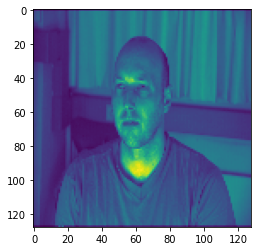

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [ ]:
img_test = torch.from_numpy(((img/(255 / 2)) -1 )).double()

In [ ]:
img_test.shape

torch.Size([128, 128])

In [ ]:
img_test=img_test.expand(1,1,128,128)

In [ ]:
img_test.shape

torch.Size([1, 1, 128, 128])

In [ ]:
fake = generator_test(img_test)

In [ ]:
fake.shape

torch.Size([1, 1, 128, 128])

In [ ]:
fake_viz = fake[0][0].detach().numpy()
# ab try karo?ha

In [ ]:
fake_viz.shape

(128, 128)

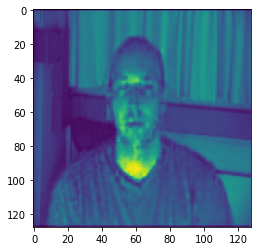

In [ ]:
plt.imshow(fake_viz)
plt.show()

In [ ]:
path = "/content/drive/My Drive/face_rotate/results2/LOG.txt"
f = open(path, "r")
print(f.read())

[0/100] [0/39] Loss_D: 1.38805703596783880371 Loss_G: 0.42905508344378867625
[0/100] [20/39] Loss_D: 1.38265858716094380831 Loss_G: 0.18156975714096415531
[1/100] [0/39] Loss_D: 1.33815542170043921821 Loss_G: 0.15975088535380743693
[1/100] [20/39] Loss_D: 1.36959546846032065304 Loss_G: 0.14311500336628854568
[2/100] [0/39] Loss_D: 1.30066391238243794781 Loss_G: 0.12694476634045476215
[2/100] [20/39] Loss_D: 1.33799735817619369627 Loss_G: 0.13113887775768551247
[3/100] [0/39] Loss_D: 1.18293110697252457086 Loss_G: 0.12547581250595579716
[3/100] [20/39] Loss_D: 1.25174524374613671540 Loss_G: 0.11285924684832650267
[4/100] [0/39] Loss_D: 1.21978670145167122918 Loss_G: 0.09716708731427151080
[4/100] [20/39] Loss_D: 1.13704250323760880370 Loss_G: 0.10073731918082459713
[5/100] [0/39] Loss_D: 1.18301300136275111541 Loss_G: 0.09711727850902202031
[5/100] [20/39] Loss_D: 1.25289757171648141743 Loss_G: 0.09459637875208497249
[6/100] [0/39] Loss_D: 1.07946716797563491141 Loss_G: 0.10044778052478

In [ ]:
f = open(path, "r")
d = []
g = []
for x in f:
  indd1 = x.index(':', 20, 25)
  # print(x[ind+2])
  indd2 = x.index('L', 25, -1)
  # print(indd2)
  # print(x[indd2-2])
  indg1 = x.index(':', 25, -1)
  # print(x[ind2+2])
  d.append(float(x[indd1+2:indd2-1]))
  g.append(float(x[indg1+2:-1]))

In [ ]:
x = []
for i in range(199):
  x.append(0.5*i)

In [ ]:
x

[0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5,
 20.0,
 20.5,
 21.0,
 21.5,
 22.0,
 22.5,
 23.0,
 23.5,
 24.0,
 24.5,
 25.0,
 25.5,
 26.0,
 26.5,
 27.0,
 27.5,
 28.0,
 28.5,
 29.0,
 29.5,
 30.0,
 30.5,
 31.0,
 31.5,
 32.0,
 32.5,
 33.0,
 33.5,
 34.0,
 34.5,
 35.0,
 35.5,
 36.0,
 36.5,
 37.0,
 37.5,
 38.0,
 38.5,
 39.0,
 39.5,
 40.0,
 40.5,
 41.0,
 41.5,
 42.0,
 42.5,
 43.0,
 43.5,
 44.0,
 44.5,
 45.0,
 45.5,
 46.0,
 46.5,
 47.0,
 47.5,
 48.0,
 48.5,
 49.0,
 49.5,
 50.0,
 50.5,
 51.0,
 51.5,
 52.0,
 52.5,
 53.0,
 53.5,
 54.0,
 54.5,
 55.0,
 55.5,
 56.0,
 56.5,
 57.0,
 57.5,
 58.0,
 58.5,
 59.0,
 59.5,
 60.0,
 60.5,
 61.0,
 61.5,
 62.0,
 62.5,
 63.0,
 63.5,
 64.0,
 64.5,
 65.0,
 65.5,
 66.0,
 66.5,
 67.0,
 67.5,
 68.0,
 68.5,
 69.0,
 69.5,
 70.0,
 70.5,
 71.0,
 71.5,
 72.0,
 72.5

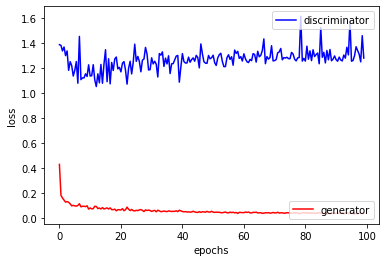

In [ ]:
import matplotlib.pyplot as plt
gen, = plt.plot(x, g, color = 'red', label="generator")
dis, = plt.plot(x, d, color = 'blue', label="discriminator")
# Create a legend for the first line.
first_legend = plt.legend(handles=[gen], loc='lower right')
ax = plt.gca().add_artist(first_legend)
second_legend = plt.legend(handles=[dis], loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()